In [1]:
# from google.colab import drive
# drive.mount("/content/gdrive")

In [2]:
# !apt update
# !apt upgrade
# !apt install gdal-bin python-gdal
# # Install rtree - Geopandas requirment
# !apt install python3-rtree 
# # Install Geopandas
# !pip install geopandas
# # Install descartes - Geopandas requirment
# !pip install descartes 

Unable to locate an executable at "/Library/Java/JavaVirtualMachines/jdk1.8.0_20.jdk/Contents/Home/bin/apt" (-1)
Unable to locate an executable at "/Library/Java/JavaVirtualMachines/jdk1.8.0_20.jdk/Contents/Home/bin/apt" (-1)
Unable to locate an executable at "/Library/Java/JavaVirtualMachines/jdk1.8.0_20.jdk/Contents/Home/bin/apt" (-1)
Unable to locate an executable at "/Library/Java/JavaVirtualMachines/jdk1.8.0_20.jdk/Contents/Home/bin/apt" (-1)
    100% |████████████████████████████████| 901kB 623kB/s ta 0:00:011
    100% |████████████████████████████████| 1.6MB 651kB/s ta 0:00:011
    100% |████████████████████████████████| 24.6MB 413kB/s ta 0:00:011
    100% |████████████████████████████████| 11.4MB 536kB/s ta 0:00:01
  Stored in directory: /Users/anthonyrentsch/Library/Caches/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built munch
You are using pip version 19.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'p

In [3]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

import datetime
import matplotlib.pyplot as plt
%matplotlib inline

# os.chdir("/content/gdrive/Team Drives/AC211_final_project/")
pd.options.display.max_columns = None

Data sources:
- Boston Crime Incident Reports (tmp8kt3hwsk.csv): downloaded [here](data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system) on 04/25/19
- Tract-level demographic data: 2013-2017 American Community Survey 5-Year Estimates. Accessed through [FactFinder](https://factfinder.census.gov/).
  - S1903: MEDIAN INCOME IN THE PAST 12 MONTHS (IN 2017 INFLATION-ADJUSTED DOLLARS)  
  - B02001: RACE 
  - B01001H: SEX BY AGE (WHITE ALONE, NOT HISPANIC OR LATINO) 
  - Tract-level vandalism records calculated by taking the number of records in the crimes dataset listed as  "vandalism" or "graffiti" (codes 1402 and 1415, respectively) per census tract, over all available dates
- Boston census tracts (Tracts_Boston_BARI.shp): Boston Area Research Initiative, BARI, 2018, "2010 Census Geographies", https://doi.org/10.7910/DVN/SQ6BT4, Harvard Dataverse, V1.

**Preparing crimes dataset**

In [0]:
df_crimes = pd.read_csv("../data/Boston_CrimeIncidentReports/tmp8kt3hwsk.csv")

# reformat datetime
df_crimes.loc[:,'OCCURRED_ON_DATE'] = pd.to_datetime(df_crimes['OCCURRED_ON_DATE'])

# Set Lat/Long=0 where previously -1 or NaN
missing_lat = (df_crimes['Lat'] == -1) | (df_crimes['Lat'].isna())
missing_long = (df_crimes['Long'] == -1) | (df_crimes['Long'].isna())
df_crimes.loc[missing_lat | missing_long, 'Lat'] = 0
df_crimes.loc[missing_lat | missing_long, 'Long'] = 0

# limit dataset to unique incidents
df_crimes = df_crimes.drop_duplicates(subset=['INCIDENT_NUMBER','OCCURRED_ON_DATE'])


# Limit type of crimes included
# ----------------------------------------------------------------------------

# limit to violent crime only 
# UCR delineates violent crimes as: 
#     - murder and nonnegligent manslaughter 
#     - rape (legacy and revised)
#     - robbery
#     - aggravated assault
#df_crimes = df_crimes.loc[(df_crimes['OFFENSE_CODE'] == 111) | 
#                          df_crimes['OFFENSE_CODE'].between(left=200, right=500),:]

# robbery only
#df_crimes = df_crimes.loc[df_crimes['OFFENSE_CODE'].between(left=300, right=400),:]

# drugs only
#df_crimes = df_crimes.loc[df_crimes['OFFENSE_CODE'].between(left=1800, right=1900),:]

# murder and nonnegligent manslaughter only
df_crimes = df_crimes.loc[(df_crimes['OFFENSE_CODE']==111)]

# aggravated assaults
#df_crimes = df_crimes.loc[df_crimes['OFFENSE_CODE'].between(left=400, right=500),:]

# Limit date range included
# ----------------------------------------------------------------------------

# limit to months for which data exist for every day of the month
df_crimes = df_crimes.loc[(df_crimes['OCCURRED_ON_DATE'] >= '2015-07-01') & 
                          (df_crimes['OCCURRED_ON_DATE'] < '2019-04-01'), :]

**Examining bias where missing locations occurred**

In [0]:
df_missingloc = df_crimes.loc[missing_lat | missing_long,:].copy()

# do obs with missing locations differ in distribution w/r/t...

# (1) district
# rates of missingness were much higher in the Downtown/Charlestown police district (A1)
display(pd.merge(left = df_missingloc['DISTRICT'].value_counts(normalize=True, dropna=False),
                 right = df_crimes['DISTRICT'].value_counts(normalize=True, dropna=False),
                 left_index = True, 
                 right_index = True,
                 suffixes=('_noloc', '')).sort_values('DISTRICT_noloc', ascending=False))


# (2) offense type
display(pd.merge(left = df_missingloc['OFFENSE_CODE_GROUP'].value_counts(normalize=True, dropna=False),
                 right = df_crimes['OFFENSE_CODE_GROUP'].value_counts(normalize=True, dropna=False),
                 left_index = True, 
                 right_index = True,
                 suffixes=('_noloc', '')).sort_values('OFFENSE_CODE_GROUP_noloc', ascending=False))

,DISTRICT_noloc,DISTRICT
C11,0.333333,0.189781
D4,0.166667,0.036496
C6,0.166667,0.065693
B2,0.166667,0.248175
A7,0.166667,0.029197


,OFFENSE_CODE_GROUP_noloc,OFFENSE_CODE_GROUP
Homicide,1.0,1.0


**Preparing Census dataset**

In [0]:
# join tract geometries to ACS data
acs17 = pd.read_csv('Census_Data/ACS_5yr_2017_combined.csv')
acs17['p_white'] = acs17['TOTAL_WHITE_NONHISP'] / acs17['TOTAL']

census_tracts = gpd.read_file('Census_Data/Tracts_Boston_2010_BARI/Tracts_Boston_BARI.shp')
census_tracts.loc[:,'GEOID'] = census_tracts['GEOID10'].astype('int')
census_tracts = census_tracts.to_crs({'init': 'epsg:4326'})

acs17 = census_tracts[['GEOID','geometry']].merge(acs17, how='left', left_on='GEOID', right_on='Id2')

**Preparing final dataset with unique census tract/month combinations**

In [0]:
# 178 census tracts, 45 month-year combos per tract --> 8010 records
months = [7,8,9,10,11,12] + list(range(1,13))*3 + [1,2,3]
years  = [2015]*6 + list(np.repeat([2016,2017,2018], 12)) + [2019]*3
tracts = np.sort(acs17['GEOID'].unique())

df_final = pd.DataFrame({"GEOID": np.repeat(tracts, len(months)),
                         "month":  np.tile(months, len(tracts)),
                         "year": np.tile(years, len(tracts))})

df_final = acs17.merge(df_final, how="right", on="GEOID")

**Joining crimes and Census data to get final dataset**

In [0]:
# (1) get total crimes per month-year, for each location
# ------------------------------------------------------
df_crime_monthly = df_crimes.groupby(['MONTH', 'YEAR', 'Lat', 'Long']).apply(len).reset_index()
df_crime_monthly.columns = df_crime_monthly.columns[:-1].tolist() + ['crime_count']

# (2) add corresponding Census tract ID to crime records based on spatial join
#     of crime lat/long to tract geometry
# ----------------------------------------------------------------------------
# add geometry column for joining to Census data
gdf_crime_monthly = gpd.GeoDataFrame(df_crime_monthly.drop(['Long', 'Lat'], axis=1),
                                     crs={'init': 'epsg:4326'},
                                     geometry=[Point(xy) for xy in zip(df_crime_monthly.Long, df_crime_monthly.Lat)])

gdf_crime_monthly = gpd.sjoin(gdf_crime_monthly, census_tracts[['GEOID','geometry']], how='left', op='intersects')

# NOTE: not all tracts joined: some just over edge of census tract. For now, removing all 17 unmatched locations,
# though should snap them to closest tract in future
unmatched_crimes = gdf_crime_monthly[gdf_crime_monthly['GEOID'].isna()]
gdf_crime_monthly = gdf_crime_monthly[gdf_crime_monthly['GEOID'].notna()]

# finally, find number of crimes per month in each census tract
gdf_crime_monthly = gdf_crime_monthly.groupby(['GEOID','MONTH','YEAR'])['crime_count'].sum().reset_index()


# (3) join crime and "backbone" dataframe based on tract ID and month
# -------------------------------------------------------------------
gdf_crime_monthly.loc[:,'GEOID'] = gdf_crime_monthly['GEOID'].astype(int)
gdf_crime_monthly.loc[:,'MONTH'] = gdf_crime_monthly['MONTH'].astype(int)
gdf_crime_monthly.loc[:,'YEAR'] = gdf_crime_monthly['YEAR'].astype(int)

df_final = pd.merge(df_final, gdf_crime_monthly, how="left", 
                    left_on=["month", "year", "GEOID"], 
                    right_on=["MONTH", "YEAR", "GEOID"])



In [0]:
# clean up final results
df_final = df_final[['GEOID', 'month', 'year', 'MED_HH_ANN_INCOME', 'p_white', 
                     'crime_count', 'counts_vandalism', 'counts_drug_crime', 
                     'counts_agg_assaults', 'geometry']]

# filling missing count values with 0's
df_final.loc[:,'crime_count'] = df_final['crime_count'].fillna(value=0)
df_final.loc[:,'counts_drug_crime'] = df_final['counts_drug_crime'].fillna(value=0)
df_final.loc[:,'counts_agg_assaults'] = df_final['counts_agg_assaults'].fillna(value=0)

df_final.loc[:,'month'] = df_final.loc[:,'month'].astype(int)
df_final.loc[:,'year'] = df_final.loc[:,'year'].astype(int)
df_final.loc[:,'crime_count'] = df_final.loc[:,'crime_count'].astype(int)
df_final.loc[:,'counts_vandalism'] = df_final.loc[:,'counts_vandalism'].astype(int)
df_final.loc[:,'counts_drug_crime'] = df_final.loc[:,'counts_drug_crime'].astype(int)
df_final.loc[:,'counts_agg_assaults'] = df_final.loc[:,'counts_agg_assaults'].astype(int)


# NOTE: capped upper bound (setting 250,000+ -> 250000) will bias results
df_final = df_final.replace({'MED_HH_ANN_INCOME': {'-': None, '250,000+':'250000'}})
df_final.loc[:,'MED_HH_ANN_INCOME'] = df_final.loc[:,'MED_HH_ANN_INCOME'].astype(np.float)

In [0]:
display(df_final)
display(df_final['crime_count'].value_counts())

In [0]:
df_final.to_csv("final_monthlymurders.csv")

In [0]:
df_final['murder'] = df_final['crime_count'] > 0
df_final['high_minority'] = (df_final['p_white'] < 0.469).astype(np.bool)


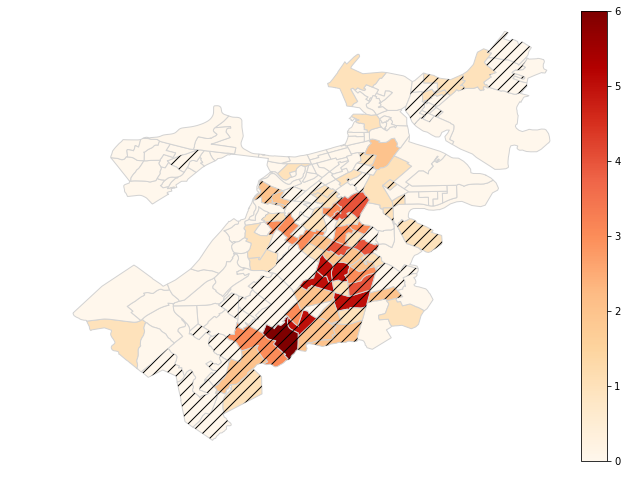

In [0]:
from google.colab import files

from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(10,10))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

census_tracts.merge(
    df_final.groupby(['GEOID'])['murder'].sum(), 
    how='left', on='GEOID'
).plot(ax=ax, column='murder', edgecolor='lightgray', legend=True, cax=cax, cmap='OrRd')


tract_high_minority = df_final[['GEOID','high_minority']].drop_duplicates()
census_tracts.merge(
    tract_high_minority,
    how='left', on='GEOID'
)[tract_high_minority['high_minority'].values].plot(ax=ax, column='high_minority', facecolor='white', alpha=0.001, linewidth=0.01, hatch="//")

ax.axis('off')

plt.savefig("map_murders_highminority.png")
files.download("map_murders_highminority.png") 